In [1]:
%load_ext autoreload
%autoreload 2

In [111]:
import os
import glob
import re
import itertools
import time
import joblib
import random

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
pd.options.display.max_colwidth = -1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, auc, roc_curve, make_scorer
from sklearn import svm, ensemble, datasets
from sklearn.model_selection import GridSearchCV

In [3]:
import parsl
parsl.clear()

from polyfuse.configs.local import config
parsl.load(config)

#parsl.load()

from polyfuse import apps, transformations

In [112]:
out_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed'
training_fraction = 0.75

In [113]:
truth = apps.concatenate_true_fusions('/cephfs/users/annawoodard/fusion-simulation/data/processed/*', out_dir)

In [114]:
truth = pd.read_hdf(truth.result(), 'data')

In [115]:
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly']
indices = dict((c, i) for i, c in enumerate(callers))

In [116]:
parsed_caller_data = apps.parse_caller_data(out_dir, callers)

In [117]:
caller_data_path = apps.concatenate_caller_data(out_dir, inputs=parsed_caller_data)
caller_data = pd.read_hdf(caller_data_path.result(), 'data')

In [118]:
samples = sorted(caller_data['sample'].unique())
#random.shuffle(samples)
training_samples = samples[:int(len(samples) * training_fraction)]
testing_samples = samples[int(len(samples) * training_fraction):]

In [119]:
training_data = [apps.assemble_data(sample, callers, out_dir) for sample in training_samples]

start = time.time()
x_train = np.array(sum([data.result()[0] for data in training_data], []))
y_train = np.array(sum([data.result()[1] for data in training_data], []))

print('assembled data in {:.1f}s'.format((time.time() - start)))

assembled data in 31.0s


In [ ]:
start = time.time()
os.makedirs(os.path.join(out_dir, 'models'), exist_ok=True)
classifiers = []
for features in [
            #['pizzly', 'starseqr', 'fusioncatcher'],
            ['pizzly', 'starfusion', 'arriba', 'fusioncatcher'],
            callers,
            #['arriba']
            #['STARSEQR', 'PIZZLY', 'PRADA', 'FUSIONCATCHER_v1.10_June192019', 'ChimeraScan', 'ARRIBA', 'MapSplice'],
            #['STARSEQR', 'PIZZLY', 'PRADA', 'FUSIONCATCHER_v1.10_June192019', 'ChimeraScan', 'ARRIBA', 'MapSplice', 'STAR_FUSION_v1.5'],
            #['STARSEQR', 'ARRIBA', 'STAR_FUSION_v1.5']
        ]:
    
    pruned_indices = [indices[f] for f in features]
    
    #label = 'LSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.LinearSVC(probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[:, pruned_indices]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(label, pruned_indices, trans)]

    #label = 'DefaultSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(probability=True)
    #classifier.fit(getattr(transformations, trans)(x_train[:, pruned_indices]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(label, pruned_indices, trans)]

    #label = 'SVC{}Features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(C=10, gamma='auto', probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[:, pruned_indices]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(label, pruned_indices, trans)]
    
    label = 'RFC{}features'.format(len(features))
    trans = 'noop'
    classifier = ensemble.RandomForestClassifier()
    classifier.fit(getattr(transformations, trans)(x_train[:, pruned_indices]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(label, pruned_indices, trans)]
    
    label = 'GBC{}features'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=750, subsample=0.9)
    classifier.fit(getattr(transformations, trans)(x_train[:, pruned_indices]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(label, pruned_indices, trans)]

    label = 'defaultGBC{}features'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier()
    classifier.fit(getattr(transformations, trans)(x_train[:, pruned_indices]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(label, pruned_indices, trans)]

print('fit models in {:.1f}s'.format((time.time() - start)))

In [121]:
x_train.shape, sum(y_train)

((55437, 5), 30000)

In [122]:
# TODO make helper function to ensure this file exists
start = time.time()
futures = []
for sample in testing_samples:
    for label, feature_indices, transformation in classifiers:
        futures += [apps.predict(sample, out_dir, label, feature_indices, transformation, callers)]
model_data = pd.concat([f.result() for f in futures])
print('assembled predictions in {:.1f}s'.format((time.time() - start)))

assembled predictions in 111.6s


In [133]:
model_data.to_hdf(os.path.join(out_dir, 'model_data.hdf'), 'data', mode='w')

In [124]:
model_data

,sample,caller,fusion,probability,prediction
0,LIB-04625wt,polyfuseRFC4features,NRBP1--ODF3L1,0.992429,1
1,LIB-04625wt,polyfuseRFC4features,GOLGA8M--SEC13,0.204188,0
2,LIB-04625wt,polyfuseRFC4features,RASAL2--STX19,0.000000,0
3,LIB-04625wt,polyfuseRFC4features,HOXC13--GDAP1L1,1.000000,1
4,LIB-04625wt,polyfuseRFC4features,CATSPERZ--OPN1MW,0.172308,0
...,...,...,...,...,...
941,LIB-04674wt,polyfuseGBCDefault5features,ADORA2A--UBN1,0.941455,1
942,LIB-04674wt,polyfuseGBCDefault5features,TBC1D3E--IL13RA1,0.133044,0
943,LIB-04674wt,polyfuseGBCDefault5features,HPD--MANSC1,0.957722,1
944,LIB-04674wt,polyfuseGBCDefault5features,MMP9--AC133555.5,0.711717,1


In [125]:
summary = apps.make_summary(out_dir, testing_samples)

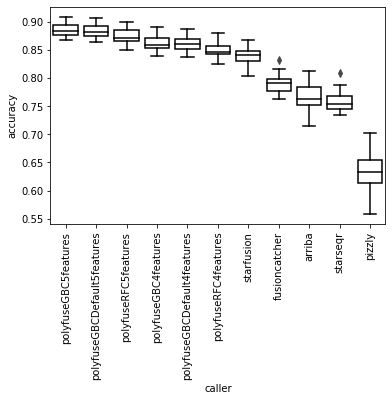

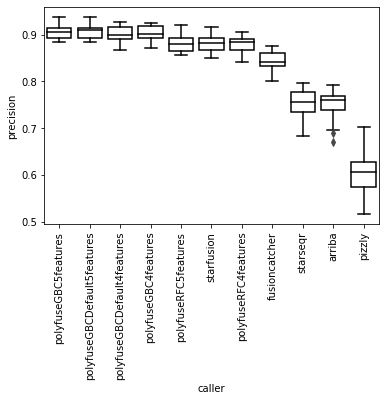

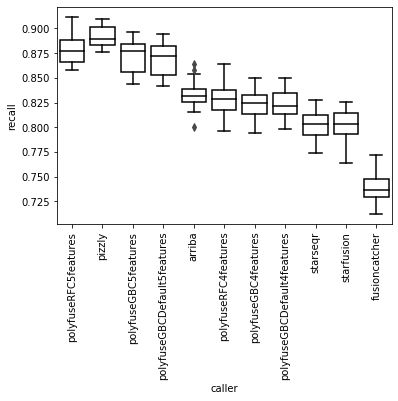

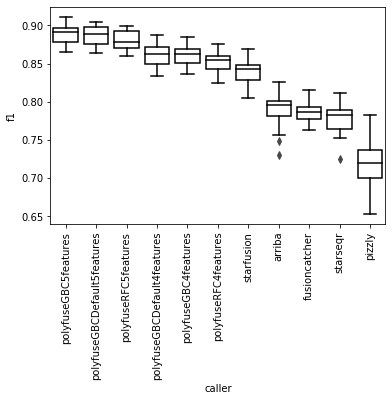

In [126]:
os.makedirs('plots', exist_ok=True)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.figure()
    ax = sns.boxplot(x="caller", y=metric, data=summary.sort_values(by=metric, ascending=False))
    labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _ = plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    _ = plt.setp(ax.lines, color='k')
    plt.savefig('plots/{}.pdf'.format(metric))

In [127]:
pd.options.display.max_rows = None
summary.groupby('caller').mean().sort_values(by='accuracy', ascending=False)

,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
caller,,,,,,,,,
polyfuseGBC5features,436.60,45.60,63.40,405.65,0.8732,0.905514,0.885320,0.889010,0.769805
polyfuseGBCDefault5features,434.25,45.15,65.75,406.10,0.8685,0.905919,0.883239,0.886742,0.765987
polyfuseRFC5features,439.35,59.05,60.65,392.20,0.8787,0.881843,0.873883,0.880139,0.745842
polyfuseGBC4features,411.65,44.55,88.35,406.70,0.8233,0.902452,0.860044,0.860995,0.722572
polyfuseGBCDefault4features,412.40,45.50,87.60,405.75,0.8248,0.900741,0.859860,0.861043,0.721941
polyfuseRFC4features,413.80,57.20,86.20,394.05,0.8276,0.878759,0.849072,0.852305,0.698386
starfusion,401.40,54.45,98.60,396.80,0.8028,0.880617,0.838720,0.839883,0.679671
fusioncatcher,369.50,69.30,130.50,381.95,0.7390,0.842423,0.789125,0.787186,0.583544
arriba,416.65,140.50,83.35,310.75,0.8333,0.748774,0.764727,0.788592,0.526544


polyfuseRFC4features
polyfuseGBC4features
polyfuseGBCDefault4features
polyfuseRFC5features
polyfuseGBC5features
polyfuseGBCDefault5features


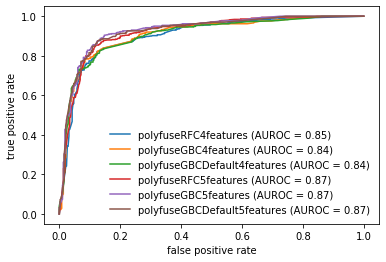

In [140]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    auroc = roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label='{} (AUROC = {:0.2f})'.format(caller, auroc))

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(frameon=False)

polyfuseRFC4features
polyfuseGBC4features
polyfuseGBCDefault4features
polyfuseRFC5features
polyfuseGBC5features
polyfuseGBCDefault5features


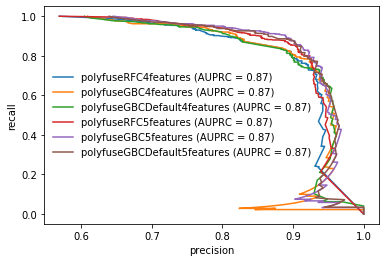

In [142]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    auprc = auc(recall, precision)
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    plt.plot(precision, recall, label='{} (AUPRC = {:0.2f})'.format(caller, auroc))

plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(frameon=False)
# looks funky, but see: https://stats.stackexchange.com/questions/183504/are-precision-and-recall-supposed-to-be-monotonic-to-classification-threshold